In [1]:
# libraries import

import pickle 

import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Conv2D, Flatten, MaxPooling2D 
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
%matplotlib inline

from keras.datasets import mnist

from keras.utils import np_utils

from collections import Counter

Using TensorFlow backend.


### MNIST Digits Dataset

Il dataset *Mnist Digits* è una base di dati di cifre scritte a mano che viene utilizzata per allenare modelli e sistemi utili all'elaborazione delle immagini. Il dataset contiene 60.000 immagini di addestramento e 10.000 immagini di testing, tutte aventi dimensioni 28X28.

Di seguito viene caricato il dataset tramite le API di Keras e viene estratto un elemento di esempio.

Infine, una rappresentazione di alcune cifre presenti.

In [2]:
# file import

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [5]:
y_train[0]

5

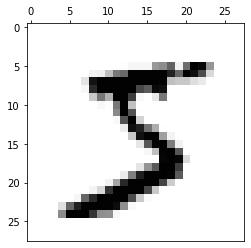

In [6]:
fig = pyplot.figure()
ax = fig.add_subplot(1,1,1)
imgplot = ax.imshow(x_train[0], cmap=mpl.cm.Greys)
imgplot.set_interpolation('nearest')
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
pyplot.show()

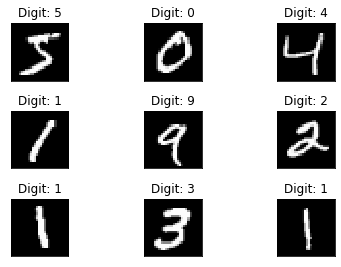

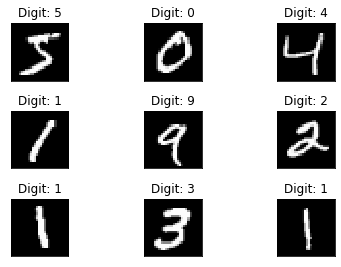

In [7]:
# rapresentation of all digits

import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Data pre-processing

In problemi di classificazione, è opportuno verificare che le classi, in questo caso 10 classi, non siano sbilanciate tra le osservazioni del training set poiché il modello potrebbe subire alcune complicazioni. 

Analizziamo, quindi, con quale frequenza si presenta ogni singola classe nel train set. 

In [8]:
# verify class balance

Counter(y_train)

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

Dall'analisi si evince che le classi sono approssimativamente equi distribuite all'interno del training set. 

Prima di sviluppare il modello, è necessario effettuare un'attività di pre-processing sulle immagini.

Si procede, quindi, con le seguenti attività:
- Resizing delle immagini, in modo tale che l'input della rete abbia una dimensione pari a 28X28X1;
- Normalizzazione dei valori dei pixel riportandoli in un intervallo tra [0,1] dividendo per 255; 
- Trasformazione delle etichette in attributi categorici, convertendoli in un vettore booleano di dimensione 10X10 (pari al numero di categorie);
- Suddivisione randomica del dataset di addestramento in training e validation, con una proporzione pari rispettivamente al 90% e 10% del dataset totale. Il validation set verrà utilizzato nella fase di validazione del modello sviluppato per valutarne la propria efficacia. 


In [9]:
# resizing (dim 28,28,1)

X_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
X_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [10]:
print('X train dim: ', X_train.shape)
print('X test dim: ', X_test.shape)

X train dim:  (60000, 28, 28, 1)
X test dim:  (10000, 28, 28, 1)


In [11]:
# convert from integers to float
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# normalize into 0-1
X_train /= 255
X_test /= 255

In [12]:
print('X train dim: ', X_train.shape)
print('X test dim: ', X_test.shape)

X train dim:  (60000, 28, 28, 1)
X test dim:  (10000, 28, 28, 1)


In [13]:
# convert class vectors to binary class matrices

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

print('Y train dim: ', Y_train.shape)
print('Y test dim: ', Y_test.shape)

Y train dim:  (60000, 10)
Y test dim:  (10000, 10)


In [14]:
# splitting train set into train-validation set

XX_train, XX_val, YY_train, YY_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 123)

In [15]:
print('X train dim: ', XX_train.shape)
print('X val dim: ', XX_val.shape)
print('Y train dim: ', YY_train.shape)
print('Y val dim: ', YY_val.shape)

X train dim:  (54000, 28, 28, 1)
X val dim:  (6000, 28, 28, 1)
Y train dim:  (54000, 10)
Y val dim:  (6000, 10)


### Model building

Questa fase consiste nella vera e propria costruzione di una *Convutional Neural Network* che permetta di classificare le immagini presenti nel test set fornito. 

Una volta sistemati i dati, è necessario definire un'architettura del modello da costruire e, ove necessario, scegliere parametri, ottimizzatori, funzione di perdita, etc. 

L'architettura sviluppata consiste in due layer convoluzionali seguiti da un layer di pooling, un layer fully-connected e un softmax layer. Per quanto riguarda il layer di Pooling, esso ha la funzione di filtrare l'input che assume, ovvero sotto-campionare le immagini riducendo la loro dimensionalità. Questo permette di ridurre l'over-fitting e lo sforzo computazionale del modello.

Per aggiungere, successivamente al Pooling, i layer fully-connected, è necessario aggiungere un Flatten, poiché essi necessitano di un input unidimensionale e quest'ultimo permette di ridurre la dimensionalità degli oggetti in input. 

Infine, sono stati inseriti due layer di dropout per regolarizzare il modello e ridurre il problema dell'over-fitting poiché c'è il rischio che le il modello si "sovradatta" ai dati di training ma non mantenga le proprie prestazioni ottime su dati non visionati. I layer di dropout permettono di "spegnere" randomicamente dei neuroni con una probabilità pari al parametro inserito.


In [16]:
# model building
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten()) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Dopo aver definito l'architettura del modello, esso viene compilato utilizzando specifiche funzioni di perdita e ottimizzatori. 
In questo caso, per quanto riguarda la funzione di perdita è stata utilizzata la *Categorical Crossentropy* in quanto il problema in questione è un problema di classificazione multi-classe. Questa funzione di loss confronta la distribuzione dei valori previsti del modello con la distribuzione dei valori originali. Richiede, però, che i valori siano espressi tramite un one-hot encoding, L’obiettivo è quello di minimizzare la funzione di perdita durante la stima dei parametri W e b.

Per l'ottimizzazione dei parametri del modello, invece, è stato utilizzato Adam, un algoritmo di ottimizzazione basato sul gradienti del prim’ordine e su stime adattive dei momenti di ordine inferiore. Questo tipo di ottimizatore può essere utilizzato e può dare prestazioni buone in caso di problemi non stazionari con gradienti rumorosi o sparsi. In particolare, è stato specificato un learning rate pari a 0.001. 

In [17]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam (lr = 1e-3),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

### Model application

Il modello è stato allenato sul training set utilizzando dei mini batch di dimensione 128, iterando per 10 epoche. Inoltre, è stato applicato utilizzando l'*early stopping*, un criterio secondo il quale se all’aumentare del numero di epoche il modello non migliora, l’iterazione si blocca.
In questo caso è stato scelto di monitorare il valore della funzione di loss calcolata sul validation test ed è stato implementato un
early stopping secondo il quale se la funzione di loss non dovesse scendere dopo 2 epoche dalla migliore, il modello si blocca. In questo caso il modello migliore si ottiene dopo 6 epoche in quanto all' ottava epoca la loss non si era ancora abbassata.

In [19]:
batch_size = 128
num_epoch = 10

# model training with early stopping
fBestModel = 'best_model.h5' 
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model_log = model.fit(XX_train, YY_train, validation_data = (XX_val, YY_val), epochs=num_epoch, 
          batch_size=batch_size, verbose=True, callbacks=[best_model, early_stop]) 

score = model.evaluate(XX_val, YY_val, batch_size=batch_size) #evaluating the models accuracy or loss,
print('validation loss, validation acc:', score)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 84s 2ms/step - loss: 0.2592 - accuracy: 0.9213 - val_loss: 0.0618 - val_accuracy: 0.9805
Epoch 2/10
54000/54000 [==============================] - 87s 2ms/step - loss: 0.0893 - accuracy: 0.9733 - val_loss: 0.0443 - val_accuracy: 0.9860
Epoch 3/10
54000/54000 [==============================] - 87s 2ms/step - loss: 0.0680 - accuracy: 0.9791 - val_loss: 0.0364 - val_accuracy: 0.9887
Epoch 4/10
54000/54000 [==============================] - 86s 2ms/step - loss: 0.0558 - accuracy: 0.9832 - val_loss: 0.0361 - val_accuracy: 0.9885
Epoch 5/10
54000/54000 [==============================] - 86s 2ms/step - loss: 0.0458 - accuracy: 0.9853 - val_loss: 0.0379 - val_accuracy: 0.9878
Epoch 6/10
54000/54000 [==============================] - 86s 2ms/step - loss: 0.0403 - accuracy: 0.9875 - val_loss: 0.0339 - val_accuracy: 0.9907
Epoch 7/10
54000/54000 [==============================] - 86s 2ms/ste

### Model evaluation

In conclusione, viene valutato il modello secondo l'accuracy e la loss da esso ottenuta. L'obiettivo è minimizzare la loss e ottenere un valore dell'accuracy prossimo a 1. 

In [20]:
# scoring

score = model.evaluate(XX_val, YY_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.0365369033259376
Validation accuracy: 0.9896666407585144


Dalle misure di loss e accuracy si evince che la rete convoluzionale sviluppata ottiene performance piuttosto soddisfacenti anche sul validation set, ovvero su dati non visionati. 

Di seguito viene visualizzato l'andamento della funzione di loss e dell'accuracy durante le 10 epoche di iterazione del modello. 

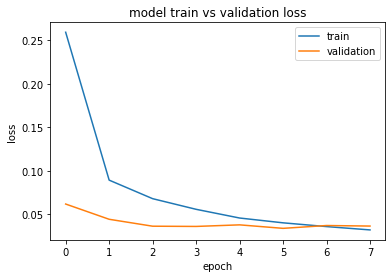

In [21]:
# loss function

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

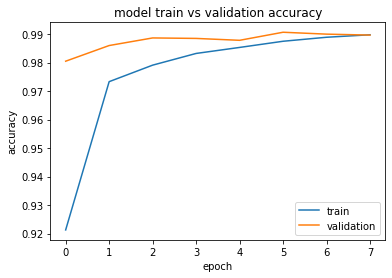

In [22]:
# accuracy

plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.show()

Anche da queste visualizzazioni si evince che le performance del modello sono piuttosto soddisfacenti in quanto l'andamento della loss tende a 0 e quello dell'accuracy tende a 1, anche se sono presenti alcuni piccolissimi picchi negativi. 

Dai grafici, inoltre, si può notare che non si presenta in maniera evidente il problema dell'over-fitting in quanto il modello fitta bene sia sui dati di training che su quelli di test.

### Prediction

Infine, il modello sviluppato viene applicato al test set per prevedere le etichette dei 10.000 record presenti. 


In [23]:
# test predictions

test_predictions = model.predict(X_test).argmax(1)
test_predictions[0]

7

Il modello prevede, ad esempio, che il primo elemento del test set sia un 7.

In [24]:
# saving file of predictions 

np.savetxt(r'Desktop/Federica_Fiorentini_807124_Ass3.txt', test_predictions, fmt='%d')